In [ ]:
from lib.ekyn import *
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch import nn
from torch.nn.functional import relu
from lib.models import *
from lib.deep_learning_utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import copy
from tqdm import tqdm


In [ ]:
ekyn_ids = get_ekyn_ids()
snezana_mice_ids = get_snezana_mice_ids()

ekyn_ids = np.array(ekyn_ids)
snezana_mice_ids = np.array(snezana_mice_ids)

ekyn_train_ids,ekyn_test_ids = train_test_split(ekyn_ids,test_size=.2,shuffle=True,random_state=0)
snezana_mice_train_ids,snezana_mice_test_ids = train_test_split(snezana_mice_ids,test_size=.2,shuffle=True,random_state=0)

train_ids = {'ekyn':ekyn_train_ids,'snezana_mice':snezana_mice_train_ids}
test_ids  = {'ekyn':ekyn_test_ids,'snezana_mice':snezana_mice_test_ids}
batch_size = 512

from torch.utils.data import DataLoader,ConcatDataset
trainloader = DataLoader(
        dataset=ConcatDataset(
        [EpochedDataset(id=id,condition=condition,robust=True,downsampled=True) for id in train_ids['ekyn'] for condition in CONDITIONS] 
        + [EpochedDataset(id=id,snezana_mice=True) for id in train_ids['snezana_mice']]
        ),
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )

testloader = DataLoader(
        dataset=ConcatDataset(
        [EpochedDataset(id=id,condition=condition,robust=True,downsampled=True) for id in test_ids['ekyn'] for condition in CONDITIONS] 
        + [EpochedDataset(id=id,snezana_mice=True) for id in test_ids['snezana_mice']]
        ),
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )
print(train_ids)
print(test_ids)
print(len(ekyn_ids),len(snezana_mice_ids))
print(f'{len(trainloader)} training batches {len(testloader)} testing batches')
print(f'{len(trainloader)*batch_size} training samples {len(testloader)*batch_size} testing samples')
print(f'{len(trainloader)*batch_size*10/3600:.2f} training hours {len(testloader)*batch_size*10/3600:.2f} testing hours')

In [47]:
model = ResNetv2(block=ResBlockv2,widthi=[64,128,256,512],depthi=[2,2,2,2],n_output_neurons=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [48]:
trainlossi = []
testlossi = []
best_model_wts = copy.deepcopy(model.state_dict())
best_dev_loss = torch.inf

In [49]:
model.to('cuda')

for i in tqdm(range(100)):
    model.train()
    for Xi,yi in trainloader:
        Xi,yi = Xi.to('cuda'),yi.to('cuda')
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainlossi.append(loss.item())

    model.eval()
    with torch.no_grad():
        loss_total = 0
        for Xi,yi in testloader:
            Xi,yi = Xi.to('cuda'),yi.to('cuda')
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
        testlossi.append(loss_total/len(testloader))
    
    if testlossi[-1] < best_dev_loss:
        best_dev_loss = testlossi[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print(best_dev_loss)
    plt.figure()
    plt.plot(torch.linspace(0,len(testlossi),len(trainlossi)),trainlossi)
    plt.plot(torch.linspace(0,len(testlossi),len(testlossi) + 1),[trainlossi[0]] + testlossi)
    plt.savefig('loss.jpg')
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [02:42<4:27:56, 162.39s/it]

0.1882094792072377


  2%|▏         | 2/100 [05:26<4:26:27, 163.14s/it]

0.1808765554846177


  2%|▏         | 2/100 [07:35<6:11:51, 227.67s/it]


KeyboardInterrupt: 

In [38]:
best_dev_loss

0.16487576898805884

0.11789811214529225
0.1705022142238752


Text(0.5, 1.0, 'testf1 : 0.876')

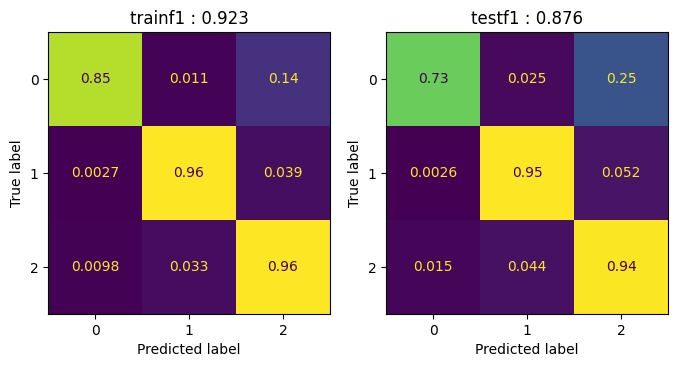

In [37]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
loss,y_true,y_pred = evaluate(dataloader=trainloader,model=model,criterion=criterion,device='cuda')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[0],colorbar=False)
axes[0].set_title(f'trainf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=criterion,device='cuda')
print(loss)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=axes[1],colorbar=False)
axes[1].set_title(f'testf1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
# first block 4
# 0.15651415670436988 
# 0.17776457286082847
# first block 8
# 0.14261297114022264
# 0.17632858462388454
# first block 16
# 0.12881732295086315
# 0.1683129257734678
